## Import Statements

Just like any other implementation, the first thing we do is do import our important libraries

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import os
from torchvision import datasets, transforms
from PIL import Image

# Discriminator Network
The discriminator network consist of the following:
1.A feature for downsampling the image and you could either use Average Pooling or Conv2d + stride, but in this case, we will be using Conv2d + stride of 2 and a padding of 1. 
2.Batch normalization layer (BatchNorm)
3.In order to avoid sparse gradients, we use a Leaky relu activation function.

In [0]:
class Discriminator(nn.Module):
    def __init__(self, alpha=0.2):
        super(Discriminator, self).__init__()

        kernel_size = 4
        padding = 1
        stride = 2
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.Conv2d(256, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 1024, kernel_size, stride, padding),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(alpha),
        )
        self.output = nn.Linear(4 * 4 * 1024, 1)
        
    def forward(self, x):
        x = self.net(x)
        x = torch.reshape(x, (-1, 4 * 4 * 1024))
        x = self.output(x)
        
        if self.training:
            return x
        
        return F.sigmoid(x)

# Generative Network

The layers of the Generator are similar to that of a discriminator, the major difference is that a generator performs UpSampling and could either use PixelShuffle, ConvTranspose2d + stride. In our own neural network, we will be using ConvTranspose2d + stride + padding .

Another feature of the generator is Tanh, which is present at the last layer. It is used to scale the input data to the interval of -1 to 1 to follow the choice of using the Tanh function.

In [0]:
class Generator(nn.Module):
    def __init__(self, input_size=200, alpha=0.2):
        super(Generator, self).__init__()       
        kernel_size = 4
        padding = 1
        stride = 2 # this is used for Upsampling
        
        self.input = nn.Linear(input_size, 4 * 4 * 1024)
        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(1024, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),  # this is used for Upsampling
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(128, 3, kernel_size, stride, padding),
            nn.Tanh()
        )
  
    def forward(self, z):
        x = self.input(z)
        return self.net(x.view(-1, 1024, 4, 4))

# Image Loader Helper Function

Now, this is one of the interesting part of this tutorial. Unlike most tutorials that uses the MNIST dataset. This provides a function that allows you to load in your own dataset and rescale the images to values between -1 and 1 so as to match the output of the generator. Now you can probably see the application of the tanh which is present at the last layer of the generator

In [0]:
class ImageFolderEX(datasets.ImageFolder):
    def __getitem__(self, index):
        def get_img(index):
            path, label = self.imgs[index]
            try:
                img = self.loader(os.path.join(self.root, path))
            except:
                img = get_img(index + 1)
            return img
        img = get_img(index)
        return self.transform(img) * 2 - 1  # rescale 0 - 1 to -1 - 1


trans = transforms.Compose([
    transforms.Resize((256, 256), interpolation=2), 
    transforms.ToTensor(), # implicitly normalizes the input to values between 0 - 1.
])




# Training Function

# Train Discriminator
The train_dis function takes in 3 parameters which are the discriminator network, generator network, and an image from the training data.
The function constructs separate mini batches for the real and fake data i.e they are not merged or shuffled into one mini batch

In [0]:
def train_dis(dis, gen, x):
    z = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)

    if next(gen.parameters()).is_cuda:
        x = x.cuda()
        z = z.cuda()

    dis.zero_grad()
    y_real_pred = dis(x)
    
    idx = np.random.uniform(0, 1, y_real_pred.shape)
    idx = np.argwhere(idx < 0.03)
    
    # swap some labels and smooth the labels
    ones = np.ones(y_real_pred.shape) + np.random.uniform(-0.1, 0.1)
    ones[idx] = 0
    
    zeros = np.zeros(y_real_pred.shape) + np.random.uniform(0, 0.2)
    zeros[idx] = 1
    ones = torch.from_numpy(ones).float()
    zeros = torch.from_numpy(zeros).float()

    if next(gen.parameters()).is_cuda:
        ones = ones.cuda()
        zeros = zeros.cuda()

    loss_real = F.binary_cross_entropy_with_logits(y_real_pred, ones)

    generated = gen(z)
    y_fake_pred = dis(generated)

    loss_fake = F.binary_cross_entropy_with_logits(y_fake_pred, zeros)
    loss = loss_fake + loss_real
    loss.backward()
    optimizer_dis.step()
    return loss




# Train Generator
Unlike the train_dis, the train_gen function takes in two inputs, namely, the generator neural networks and the batch size. Batch size is basically the number of training examples used in one epoch or iteration. The remainder of the function is quite similar to train_dis

In [0]:
def train_gen(gen, batch_size):
    z = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
    
    if next(gen.parameters()).is_cuda:
        z = z.cuda()
    
    gen.zero_grad()
    generated = gen(z)
    y_fake = dis(generated)

    ones = torch.ones_like(y_fake)
    if next(gen.parameters()).is_cuda:
        ones = ones.cuda()

    loss = F.binary_cross_entropy_with_logits(y_fake, ones)
    loss.backward()
    optimizer_gen.step()
    return loss, generated

# Load Training Data Path

In [0]:
path = '/content/drive/My Drive/flowers/flowers'

# Putting Everything together

In [8]:
dis = Discriminator().cuda()
gen = Generator().cuda()

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
optimizer_gen = torch.optim.Adam(gen.parameters(), lr, betas=(beta_1, beta_2))
optimizer_dis = torch.optim.Adam(dis.parameters(), lr, betas=(beta_1, beta_2))

epochs = 20
batch_size = 64
data = torch.utils.data.DataLoader(ImageFolderEX(path, trans), 
				   batch_size=batch_size, shuffle=True, 
				   drop_last=True, num_workers=2)

n = len(data)
for epoch in range(0, epochs):
    c = 0
    n = len(data) 

    for x in iter(data): 
        c += 1

        loss_dis = train_dis(dis, gen, x)
        loss_gen, generated = train_gen(gen, batch_size)
        
        global_step = epoch * n + c

        if c % 4 == 0:
            print(f'loss: {loss_dis.item()}, \t {loss_gen.item()} \t epoch: {epoch}, \t {c}/{n}')

loss: 5.576929569244385, 	 5.372687339782715 	 epoch: 0, 	 4/66
loss: 1.4617022275924683, 	 3.920471668243408 	 epoch: 0, 	 8/66
loss: 8.68019962310791, 	 7.565273761749268 	 epoch: 0, 	 12/66
loss: 0.5478898286819458, 	 5.920862197875977 	 epoch: 0, 	 16/66
loss: 0.6380147933959961, 	 6.198117733001709 	 epoch: 0, 	 20/66
loss: 0.7795611619949341, 	 2.917654037475586 	 epoch: 0, 	 24/66
loss: 0.25222545862197876, 	 3.2660295963287354 	 epoch: 0, 	 28/66
loss: 0.7167232632637024, 	 2.489046573638916 	 epoch: 0, 	 32/66
loss: 1.3394205570220947, 	 1.6135923862457275 	 epoch: 0, 	 36/66
loss: 1.3489656448364258, 	 7.350872039794922 	 epoch: 0, 	 40/66
loss: 0.11694619804620743, 	 2.297363758087158 	 epoch: 0, 	 44/66
loss: 1.74953293800354, 	 9.301778793334961 	 epoch: 0, 	 48/66
loss: 0.6155112981796265, 	 2.048252582550049 	 epoch: 0, 	 52/66
loss: -0.1662106215953827, 	 3.6214656829833984 	 epoch: 0, 	 56/66
loss: 1.0992251634597778, 	 6.48607873916626 	 epoch: 0, 	 60/66
loss: 0.3887

In [24]:
#Saving the model
gen = gen.to('cpu')
torch.save(gen, path+'gen_cpu.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
path = '/content/drive/My Drive/flowers/flowersgen_cpu.pth'
gen = Generator().to("cpu")
gen = torch.load(path)
gen.eval()

Generator(
  (input): Linear(in_features=200, out_features=16384, bias=True)
  (net): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, 

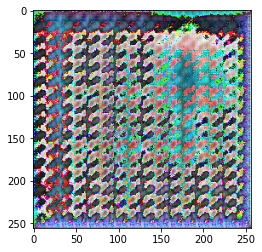

In [25]:
import matplotlib.pyplot as plt
z = torch.tensor(np.random.normal(0, 1, (10, 200)), dtype=torch.float32)
gen = gen.to('cpu')
img = gen(z)
img = transforms.ToPILImage(mode=None)(img[0])
plt.imshow(img)


In [0]:
img.save('img_gan_1.png')